# Machine Learning for Level Truncation in Open String Field Theory

Harold Erbin, Riccardo Finotello, Matej Kudrna, Martin Schnabl

---
---

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

In this notebook we perform a linear regression analysis and inference. We study the contribution of each variable to the fit and study separately the cases of high and low weights. As a general rule in this case we are not necessarily interested in getting the best prediction, but we want to study the contributions of each feature to the output: we will not scale the data and will not consider the _intercept_ of the linear models (as we assume that the features cannot be all vanishing at the same time).

For the analysis we will in general keep 80% of the samples in the training set and 20% in the test set. The distinction however is made on the basis of the `solutions` column: we first divide its unique values into training and test sets and then assign the corresponding samples to the sets. This way we keep data from the same solutions inside the same set.

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.makedirs('./models', exist_ok=True)

## Regression Analysis w/ the Full Dataset

We first consider the full dataset without distinctions on the weights:

In [2]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda.csv')

# drop the first solution (too correlated to the output)
df = df.loc[df['solutions'] != 0]

We then divide the dataset into training and test sets:

In [3]:
from sklearn.model_selection import train_test_split

RAND = 123
sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, train_size=0.8, shuffle=True, random_state=RAND)

# divide training and test sets
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

# clean columns and separate the labels
exp_train = df_train['exp']
exp_test  = df_test['exp']

df_train  = df_train.drop(columns=['solutions', 'init', 'exp'])
df_test   = df_test.drop(columns=['solutions', 'init', 'exp'])

# check the size
print('Training ratio: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))

Training ratio: 80.92%


In order to get the predictions we prepare the estimator (a simple linear regressor in this case) and save everything we need for later:

In [4]:
from sklearn.linear_model import LinearRegression
import joblib

# define the estimator and save it
estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
joblib.dump(estimator, './models/lr_prelim_full.pkl')

# save training and test sets
df_train.to_csv('./data/data_train_full_80.csv', index=False)
df_test.to_csv('./data/data_test_full_20.csv', index=False)

exp_train.to_csv('./data/labels_train_full_80.csv', index=False)
exp_test.to_csv('./data/labels_test_full_20.csv', index=False)

We then train the model and compute its predictions:

In [5]:
TRAIN  = './data/data_train_full_80.csv'
LABELS = './data/labels_train_full_80.csv'
ESTIM  = './models/lr_prelim_full.pkl'

!python3 ./scripts/scikit-train.py --train {TRAIN} --labels {LABELS} --estimator {ESTIM}

LinearRegression trained in 0.005 seconds.


In [6]:
TEST   = './data/data_test_full_20.csv'
LABELS = './data/labels_test_full_20.csv'
ESTIM  = './models/lr_prelim_full.pkl'
OUTPUT = 'lr_prelim_full'

!python3 ./scripts/scikit-predict.py --test {TEST} --labels {LABELS} --estimator {ESTIM} --output {OUTPUT}

LinearRegression predicted in 0.001 seconds.


In [7]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lr_prelim_full,118,0.162297,0.095317,0.229277,0.402861,0.288296,0.683418


We then perform the analysis of the variance (ANOVA) and study the coefficients of the fit:

In [8]:
DATA   = './predictions/lr_prelim_full.csv'
ESTIM  = './models/lr_prelim_full.pkl'
OUTPUT = 'lr_prelim_full_anova'

!python3 ./scripts/scikit-anova.py --data {DATA} --estimator {ESTIM} --output {OUTPUT}

In [9]:
import pandas as pd

pd.read_csv('./metrics/{}.csv'.format(OUTPUT), index_col=0)

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.109066,1.549367e-02,7.039,0.000,0.073890,0.144242
type,0.033793,5.489023e-02,0.616,0.539,-0.090828,0.158413
level_2,-0.066685,7.277568e-03,-9.162,0.000,-0.083208,-0.050163
level_3,0.135235,6.691568e-03,20.207,0.000,0.120043,0.150427
level_4,-0.295528,1.484723e-03,-198.912,0.000,-0.298899,-0.292158
level_5,0.416140,1.403271e-03,296.339,0.000,0.412954,0.419326
level_6,-0.290419,3.137990e-04,-922.553,0.000,-0.291131,-0.289706
level_7,0.452731,2.996969e-04,1505.606,0.000,0.452050,0.453411
level_8,-0.413452,6.021060e-05,-6754.594,0.000,-0.413589,-0.413316
level_9,0.576754,5.794050e-05,9785.356,0.000,0.576622,0.576885


The determination of the coefficients is in general extremely precise (apart for the `type` variable which can be taken to vanish) and in general the coefficients are not zero (well within the confidence interval).

Ultimately we take a look at the residual plots and the histograms:

In [10]:
PREDS  = './predictions/lr_prelim_full.csv'
OUTPUT = 'lr_prelim_full'

!python3 ./scripts/summary.py --data {PREDS} --output {OUTPUT}

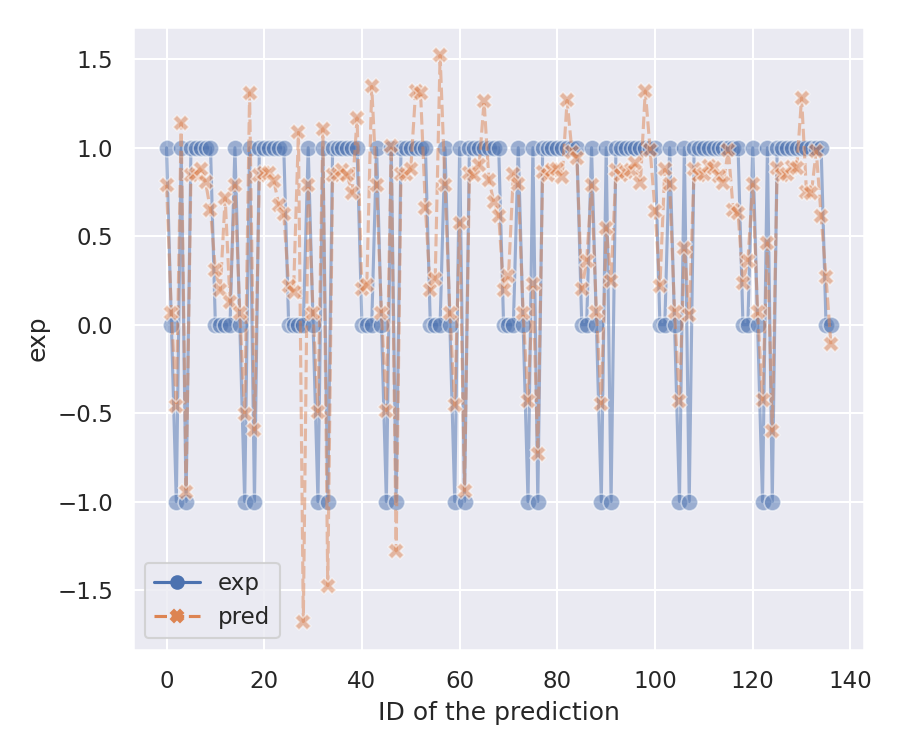

In [11]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT), width=480)

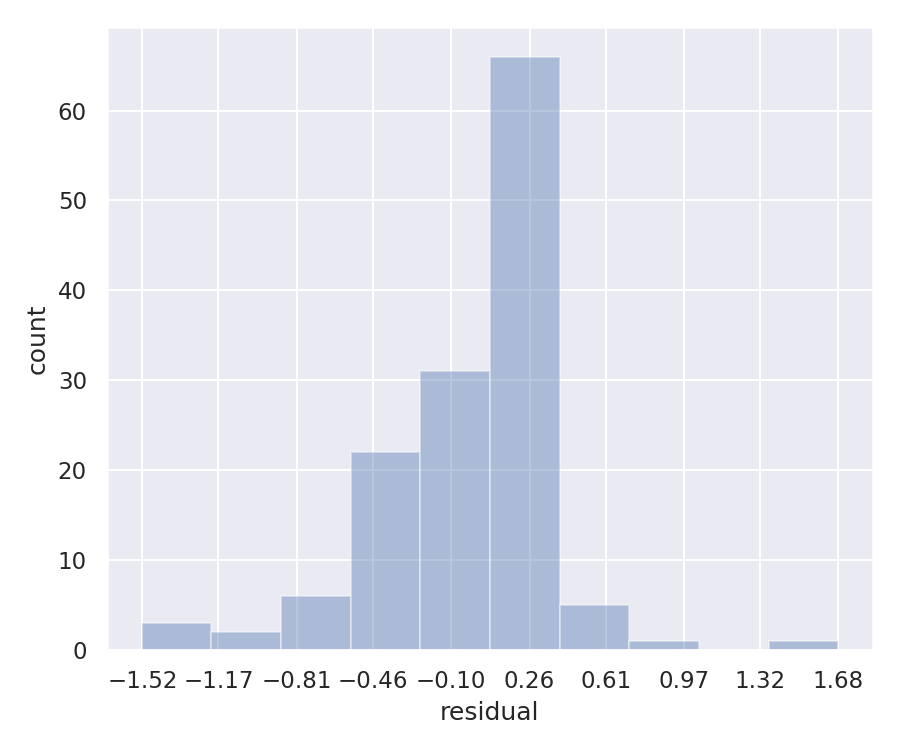

In [12]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT), width=480)

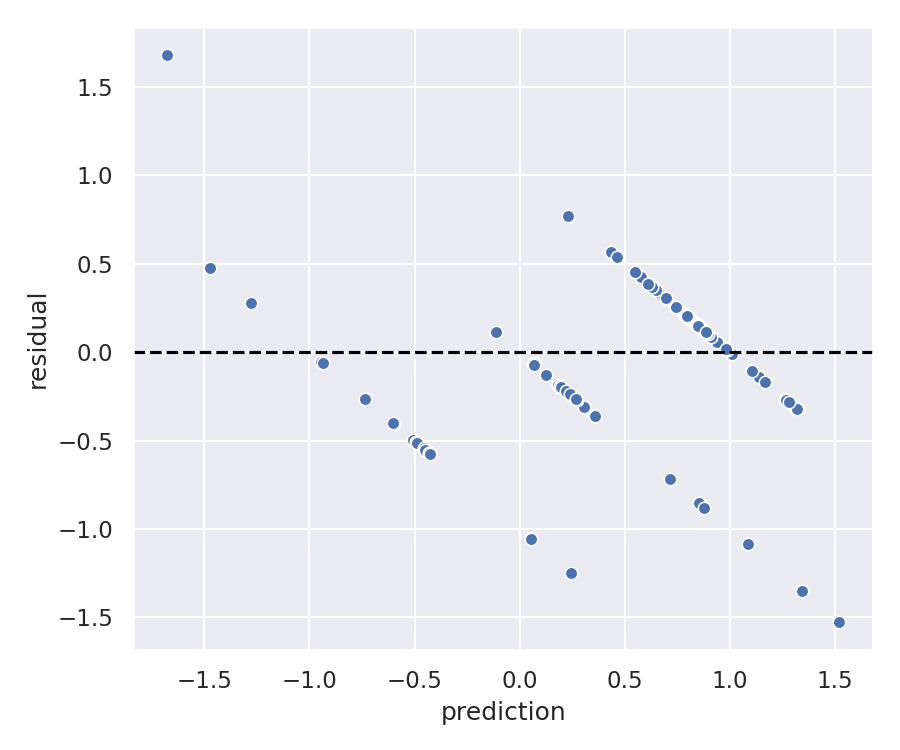

In [13]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT), width=480)

## Regression Analysis w/ `weight` $< 1.5$

In [14]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda_low.csv')

# drop the first solution (too correlated to the output)
df = df.loc[df['solutions'] != 0]

We then divide the dataset into training and test sets:

In [15]:
from sklearn.model_selection import train_test_split

RAND = 123
sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, train_size=0.8, shuffle=True, random_state=RAND)

# divide training and test sets
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

# clean columns and separate the labels
exp_train = df_train['exp']
exp_test  = df_test['exp']

df_train  = df_train.drop(columns=['solutions', 'init', 'exp'])
df_test   = df_test.drop(columns=['solutions', 'init', 'exp'])

# check the size
print('Training ratio: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))

Training ratio: 81.02%


In order to get the predictions we prepare the estimator (a simple linear regressor in this case) and save everything we need for later:

In [16]:
from sklearn.linear_model import LinearRegression
import joblib

# define the estimator and save it
estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
joblib.dump(estimator, './models/lr_prelim_low.pkl')

# save training and test sets
df_train.to_csv('./data/data_train_low_80.csv', index=False)
df_test.to_csv('./data/data_test_low_20.csv', index=False)

exp_train.to_csv('./data/labels_train_low_80.csv', index=False)
exp_test.to_csv('./data/labels_test_low_20.csv', index=False)

We then train the model and compute its predictions:

In [17]:
TRAIN  = './data/data_train_low_80.csv'
LABELS = './data/labels_train_low_80.csv'
ESTIM  = './models/lr_prelim_low.pkl'

!python3 ./scripts/scikit-train.py --train {TRAIN} --labels {LABELS} --estimator {ESTIM}

LinearRegression trained in 0.001 seconds.


In [18]:
TEST   = './data/data_test_low_20.csv'
LABELS = './data/labels_test_low_20.csv'
ESTIM  = './models/lr_prelim_low.pkl'
OUTPUT = 'lr_prelim_low'

!python3 ./scripts/scikit-predict.py --test {TEST} --labels {LABELS} --estimator {ESTIM} --output {OUTPUT}

LinearRegression predicted in 0.001 seconds.


In [19]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lr_prelim_low,59,0.00233,-0.000262,0.004921,0.048265,0.026922,0.995153


We immediately notice an improvement in the predictions when splitting the dataset. In fact both MSE and R2 scores are definitely better than before. As a summary we can then take a look at the regression analysis for `weight` $<1.5$:

In [20]:
DATA   = './predictions/lr_prelim_low.csv'
ESTIM  = './models/lr_prelim_low.pkl'
OUTPUT = 'lr_prelim_low_anova'

!python3 ./scripts/scikit-anova.py --data {DATA} --estimator {ESTIM} --output {OUTPUT}

In [21]:
import pandas as pd

pd.read_csv('./metrics/{}.csv'.format(OUTPUT), index_col=0)

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,-0.031801,0.013266,-2.397,0.020,-0.062314,-0.001288
type,0.003728,0.007457,0.500,0.619,-0.013424,0.020879
level_2,-0.347830,0.007659,-45.409,0.000,-0.365446,-0.330214
level_3,0.231636,0.006819,33.965,0.000,0.215952,0.247319
level_4,1.315575,0.009134,144.021,0.000,1.294567,1.336582
level_5,-4.097718,0.008826,-464.239,0.000,-4.118018,-4.077419
level_6,41.079494,0.007035,5838.873,0.000,41.063314,41.095674
level_7,-48.609417,0.007175,-6774.301,0.000,-48.625919,-48.592915
level_8,60.035153,0.009043,6638.038,0.000,60.014354,60.055953
level_9,-30.707944,0.008742,-3512.338,0.000,-30.728051,-30.687838


The determination of the coefficients is in general extremely precise (apart for the `type` variable which can be taken to vanish) and in general the coefficients are not zero (well within the confidence interval).

Ultimately we take a look at the residual plots and the histograms:

In [22]:
PREDS  = './predictions/lr_prelim_low.csv'
OUTPUT = 'lr_prelim_low'

!python3 ./scripts/summary.py --data {PREDS} --output {OUTPUT}

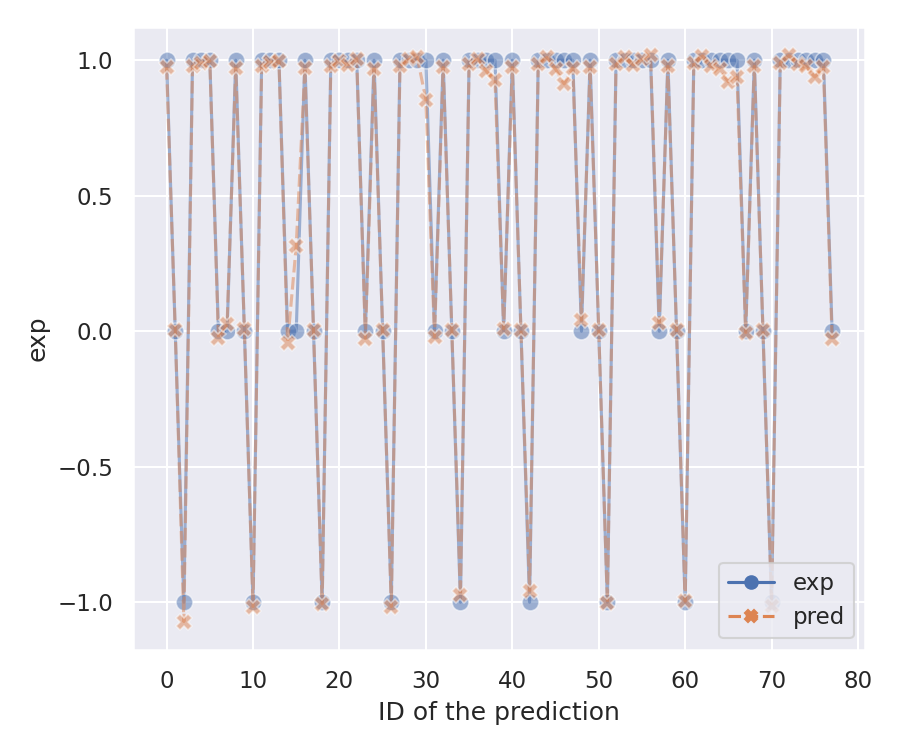

In [23]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT), width=480)

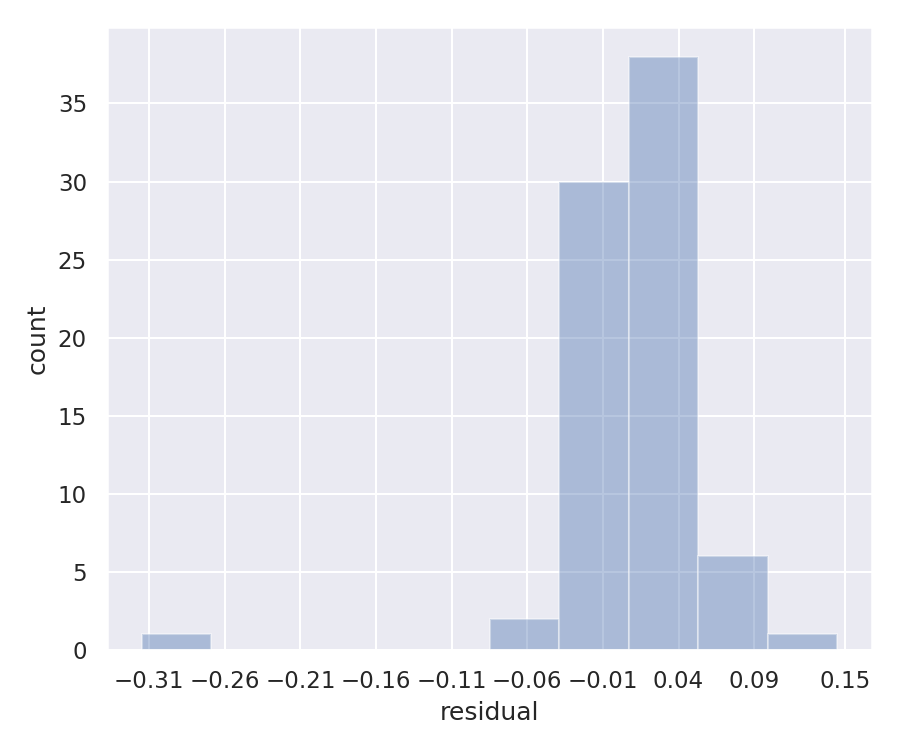

In [24]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT), width=480)

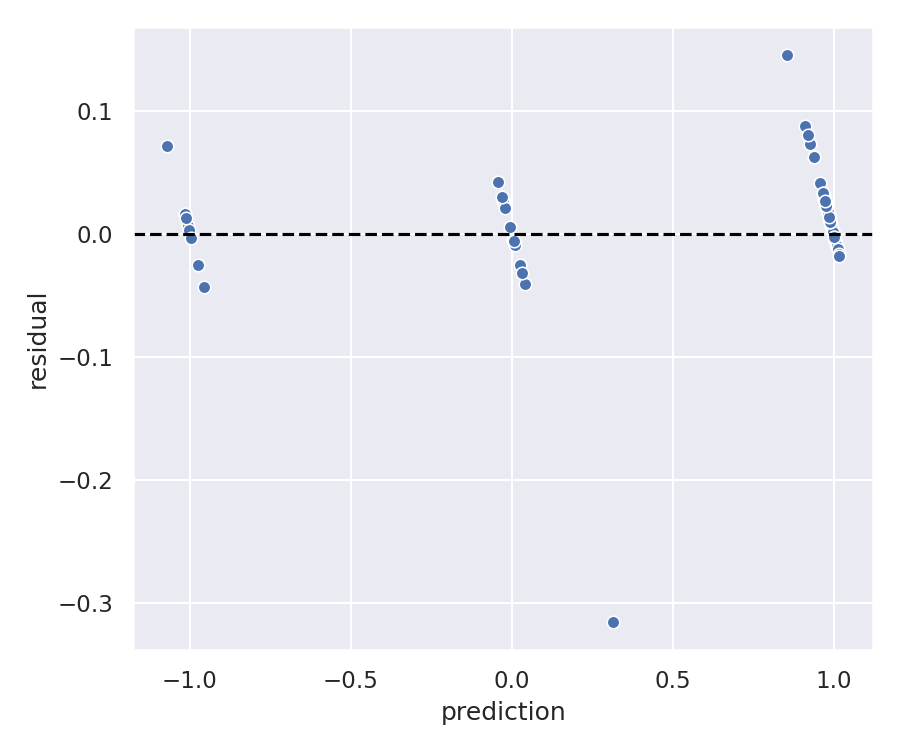

In [25]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT), width=480)

## Regression Analysis w/ `weight` $\ge 1.5$

In [26]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda_high.csv')

# drop the first solution (too correlated to the output)
df = df.loc[df['solutions'] != 0]

We then divide the dataset into training and test sets:

In [27]:
from sklearn.model_selection import train_test_split

RAND = 123
sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, train_size=0.8, shuffle=True, random_state=RAND)

# divide training and test sets
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

# clean columns and separate the labels
exp_train = df_train['exp']
exp_test  = df_test['exp']

df_train  = df_train.drop(columns=['solutions', 'init', 'exp'])
df_test   = df_test.drop(columns=['solutions', 'init', 'exp'])

# check the size
print('Training ratio: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))

Training ratio: 80.78%


In order to get the predictions we prepare the estimator (a simple linear regressor in this case) and save everything we need for later:

In [28]:
from sklearn.linear_model import LinearRegression
import joblib

# define the estimator and save it
estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
joblib.dump(estimator, './models/lr_prelim_high.pkl')

# save training and test sets
df_train.to_csv('./data/data_train_high_80.csv', index=False)
df_test.to_csv('./data/data_test_high_20.csv', index=False)

exp_train.to_csv('./data/labels_train_high_80.csv', index=False)
exp_test.to_csv('./data/labels_test_high_20.csv', index=False)

We then train the model and compute its predictions:

In [29]:
TRAIN  = './data/data_train_high_80.csv'
LABELS = './data/labels_train_high_80.csv'
ESTIM  = './models/lr_prelim_high.pkl'

!python3 ./scripts/scikit-train.py --train {TRAIN} --labels {LABELS} --estimator {ESTIM}

LinearRegression trained in 0.001 seconds.


In [30]:
TEST   = './data/data_test_high_20.csv'
LABELS = './data/labels_test_high_20.csv'
ESTIM  = './models/lr_prelim_high.pkl'
OUTPUT = 'lr_prelim_high'

!python3 ./scripts/scikit-predict.py --test {TEST} --labels {LABELS} --estimator {ESTIM} --output {OUTPUT}

LinearRegression predicted in 0.001 seconds.


In [31]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lr_prelim_high,40,0.071848,0.034754,0.108942,0.268044,0.200753,0.870145


Even though the metrics seem to improve with respect to the full dataset, results are definitely lower than the case with lower weights.

In [32]:
DATA   = './predictions/lr_prelim_high.csv'
ESTIM  = './models/lr_prelim_high.pkl'
OUTPUT = 'lr_prelim_high_anova'

!python3 ./scripts/scikit-anova.py --data {DATA} --estimator {ESTIM} --output {OUTPUT}

In [33]:
import pandas as pd

pd.read_csv('./metrics/{}.csv'.format(OUTPUT), index_col=0)

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,-0.016278,1.879004e-02,-0.866,0.392,-0.060039,0.027483
type,0.222552,3.255385e+02,0.001,0.999,-757.935278,758.380382
level_2,-0.706409,6.638855e-03,-106.389,0.000,-0.721870,-0.690947
level_3,0.569206,6.113268e-03,93.095,0.000,0.554968,0.583443
level_4,-0.718673,1.241226e-03,-578.537,0.000,-0.721564,-0.715783
level_5,0.535358,1.172338e-03,456.269,0.000,0.532628,0.538089
level_6,-0.422119,2.569056e-04,-1636.718,0.000,-0.422717,-0.421520
level_7,0.331848,2.452602e-04,1347.552,0.000,0.331277,0.332420
level_8,-0.306345,4.824910e-05,-6220.323,0.000,-0.306458,-0.306233
level_9,0.264757,4.643860e-05,5581.058,0.000,0.264649,0.264866


The determination of the coefficients is in general extremely precise (apart for the `type` variable which can be taken to vanish and the `weight` variable which, as the EDA showed, is not necessary when considering `weight` $\ge 1.5$).

Ultimately we take a look at the residual plots and the histograms:

In [34]:
PREDS  = './predictions/lr_prelim_high.csv'
OUTPUT = 'lr_prelim_high'

!python3 ./scripts/summary.py --data {PREDS} --output {OUTPUT}

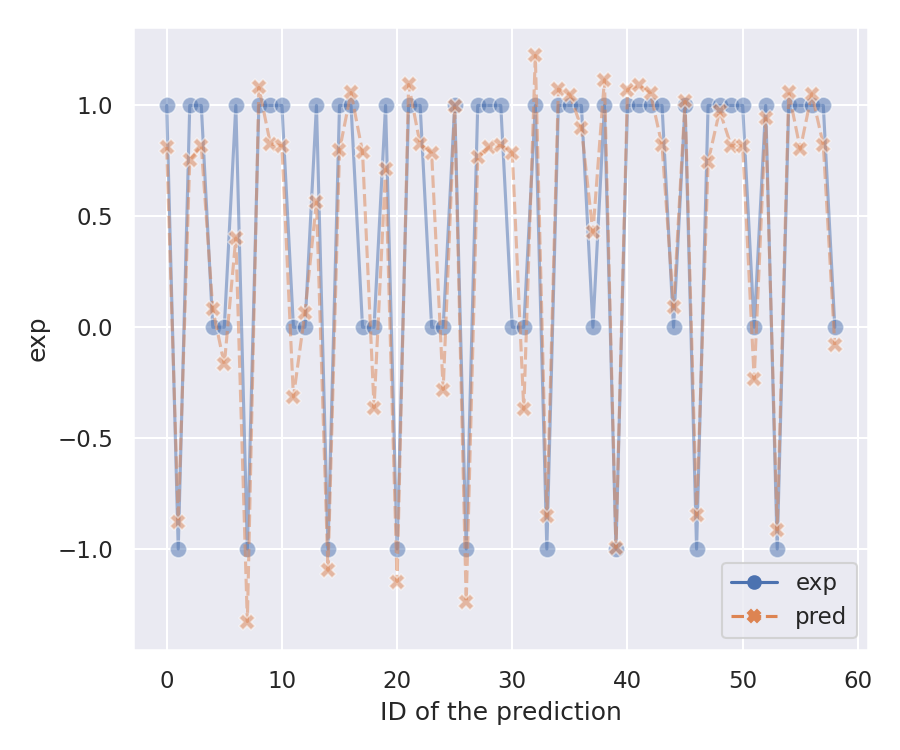

In [35]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT), width=480)

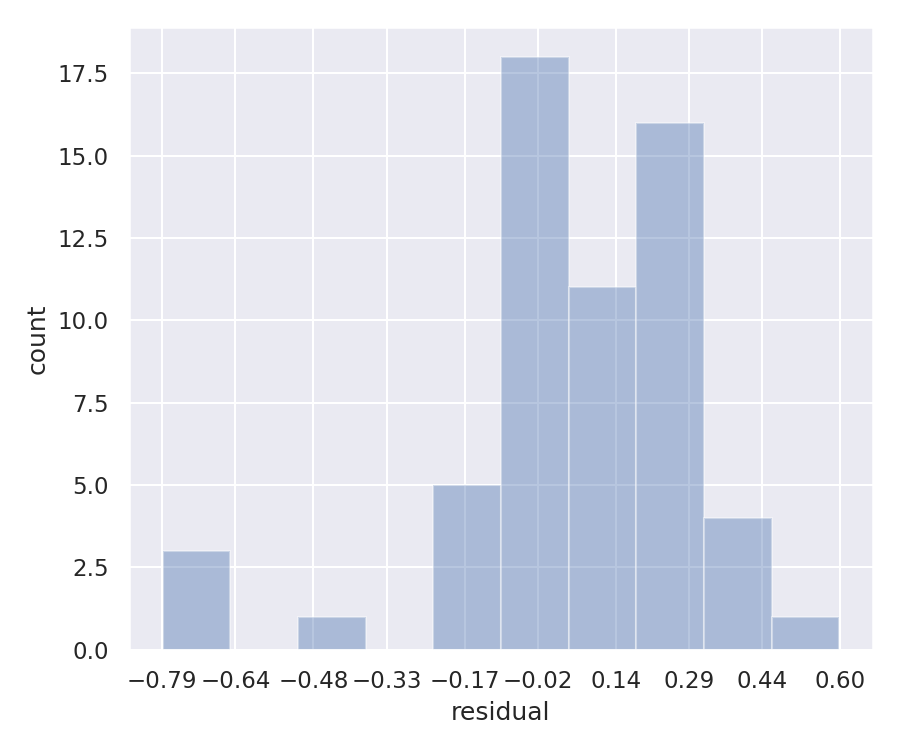

In [36]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT), width=480)

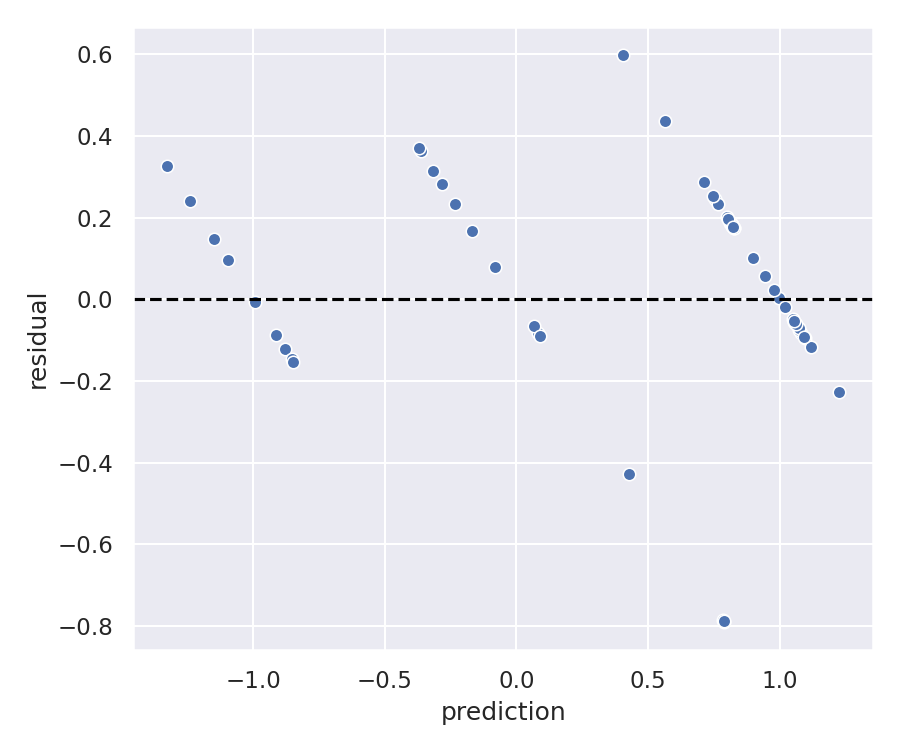

In [37]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT), width=480)

## Regression Analysis w/o the `type` Variable

In [38]:
import pandas as pd

# load the dataset
df = pd.read_csv('./data/sft-trunc_eda.csv')

# drop the first solution (too correlated to the output)
df = df.loc[df['solutions'] != 0]

# drop the type columns
df = df.drop(columns=['type'])

We then divide the dataset into training and test sets:

In [39]:
from sklearn.model_selection import train_test_split

RAND = 123
sol = df['solutions'].unique()

sol_train, sol_test = train_test_split(sol, train_size=0.8, shuffle=True, random_state=RAND)

# divide training and test sets
df_train = df.loc[df['solutions'].isin(sol_train)]
df_test  = df.loc[df['solutions'].isin(sol_test)]

# clean columns and separate the labels
exp_train = df_train['exp']
exp_test  = df_test['exp']

df_train  = df_train.drop(columns=['solutions', 'init', 'exp'])
df_test   = df_test.drop(columns=['solutions', 'init', 'exp'])

# check the size
print('Training ratio: {:.2f}%'.format(100 * df_train.shape[0] / df.shape[0]))

Training ratio: 80.92%


In order to get the predictions we prepare the estimator (a simple linear regressor in this case) and save everything we need for later:

In [40]:
from sklearn.linear_model import LinearRegression
import joblib

# define the estimator and save it
estimator = LinearRegression(fit_intercept=False, normalize=False, n_jobs=-1)
joblib.dump(estimator, './models/lr_prelim_notype.pkl')

# save training and test sets
df_train.to_csv('./data/data_train_notype_80.csv', index=False)
df_test.to_csv('./data/data_test_notype_20.csv', index=False)

exp_train.to_csv('./data/labels_train_notype_80.csv', index=False)
exp_test.to_csv('./data/labels_test_notype_20.csv', index=False)

We then train the model and compute its predictions:

In [41]:
TRAIN  = './data/data_train_notype_80.csv'
LABELS = './data/labels_train_notype_80.csv'
ESTIM  = './models/lr_prelim_notype.pkl'

!python3 ./scripts/scikit-train.py --train {TRAIN} --labels {LABELS} --estimator {ESTIM}

LinearRegression trained in 0.002 seconds.


In [42]:
TEST   = './data/data_test_notype_20.csv'
LABELS = './data/labels_test_notype_20.csv'
ESTIM  = './models/lr_prelim_notype.pkl'
OUTPUT = 'lr_prelim_notype'

!python3 ./scripts/scikit-predict.py --test {TEST} --labels {LABELS} --estimator {ESTIM} --output {OUTPUT}

LinearRegression predicted in 0.001 seconds.


In [43]:
import json

with open('./metrics/{}.json'.format(OUTPUT, 'r')) as f:
    metrics = pd.DataFrame(json.load(f), index=[OUTPUT])
    
metrics

,DOF,MSE,MSE 95% CI (lower),MSE 95% CI (upper),RMSE,MAE,R2
lr_prelim_notype,119,0.170778,0.09179,0.249766,0.413253,0.284016,0.666875


We immediately notice that results did not improve when removing the variable: we may want to keep it when training.

We then perform the analysis of the variance (ANOVA) and study the coefficients of the fit:

In [44]:
DATA   = './predictions/lr_prelim_notype.csv'
ESTIM  = './models/lr_prelim_notype.pkl'
OUTPUT = 'lr_prelim_notype_anova'

!python3 ./scripts/scikit-anova.py --data {DATA} --estimator {ESTIM} --output {OUTPUT}

In [45]:
import pandas as pd

pd.read_csv('./metrics/{}.csv'.format(OUTPUT), index_col=0)

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.151919,1.582642e-02,9.598,0.0,0.115991,0.187847
level_2,-0.040146,7.433861e-03,-5.400,0.0,-0.057022,-0.023270
level_3,0.123187,6.835277e-03,18.020,0.0,0.107670,0.138704
level_4,-0.283183,1.516609e-03,-186.598,0.0,-0.286626,-0.279740
level_5,0.430541,1.433408e-03,300.153,0.0,0.427287,0.433795
level_6,-0.278995,3.205381e-04,-867.688,0.0,-0.279722,-0.278267
level_7,0.462156,3.061331e-04,1504.741,0.0,0.461461,0.462851
level_8,-0.401072,6.150360e-05,-6416.773,0.0,-0.401211,-0.400932
level_9,0.576797,5.918480e-05,9583.756,0.0,0.576662,0.576931
level_10,-0.306283,1.347900e-05,-21153.560,0.0,-0.306314,-0.306252


In this case we cannot set any coefficient to 0.

Ultimately we take a look at the residual plots and the histograms:

In [46]:
PREDS  = './predictions/lr_prelim_notype.csv'
OUTPUT = 'lr_prelim_notype'

!python3 ./scripts/summary.py --data {PREDS} --output {OUTPUT}

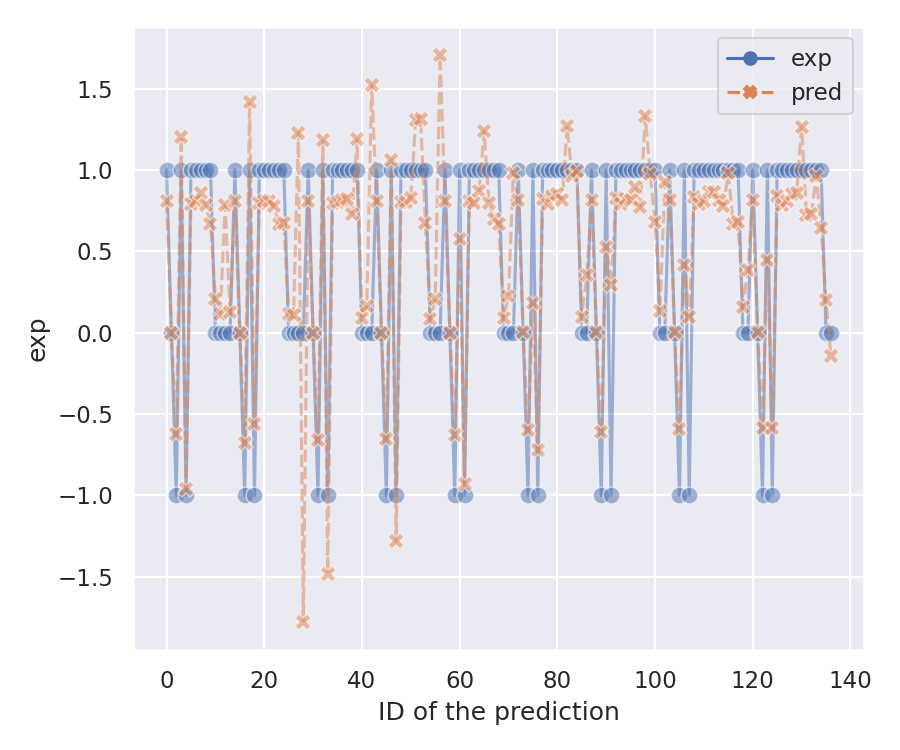

In [47]:
from IPython.display import Image
Image('./img/{}_lineplot.png'.format(OUTPUT), width=480)

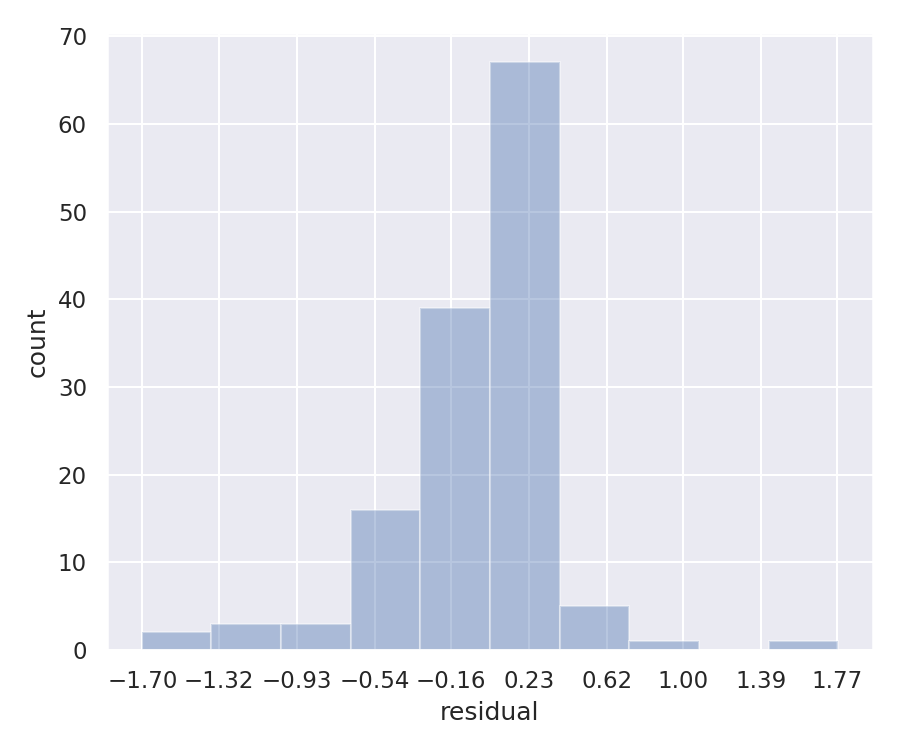

In [48]:
from IPython.display import Image
Image('./img/{}_histogram.png'.format(OUTPUT), width=480)

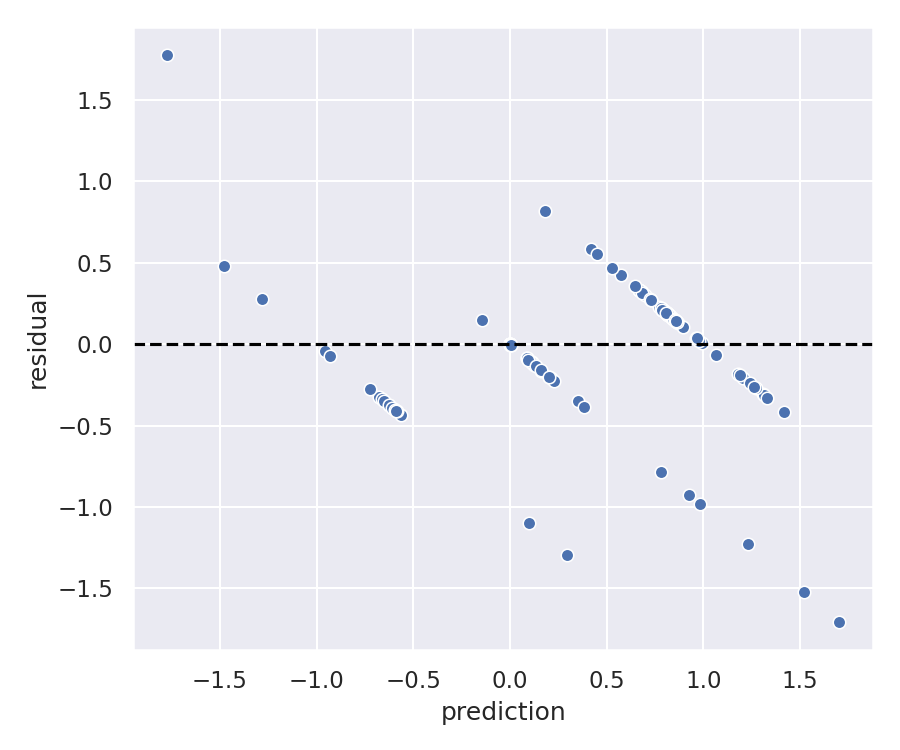

In [49]:
from IPython.display import Image
Image('./img/{}_resplot.png'.format(OUTPUT), width=480)